# **Volatility Skew Trading**

Volatility skew is a well-known phenomenon in the options market that refers to the difference in implied volatility (IV) between out-of-the-money (OTM) calls and puts. This skew arises from market sentiment, supply and demand imbalances, and behavioral factors — most notably loss aversion.

## Why Trade the Skew?

Options were originally introduced as hedging instruments, and many investors are willing to overpay for downside protection. This behavioral bias is well described by **Prospect Theory** (Kahneman & Tversky, 1979), which suggests that individuals tend to overweight small-probability events and exhibit strong aversion to losses.

As options traders, we can exploit these persistent mispricings by constructing volatility skew trading strategies, aiming to profit when market-implied fears (e.g., demand for puts) fail to materialize. These strategies typically assume that the pricing dislocation is temporary or exaggerated relative to actual realized outcomes.

The notebook is structured as follows:

1. [Read SPX Options Data](#read_data)
2. [Plot the Implied Volatility Skew](#plot_iv)
3. [Remove illiquid Options](#illiquid)
4. [Build the Synthetic 30-DTE Skew](#skew)
5. [Implement Trading Strategies](#construct-strategy)
   - [5.1. Trade Execution Setup](#trade-execution-setup)
   - [5.2 Strategy 1: Simple Mean Reversion on the Skew](#strategy1-mean-reversion)
       - [5.2.1 Signal 1: Fixed Absolute Skew Threshold](#signal-fixed-threshold)
       - [5.2.2 Signal 2: Rolling Z-Score of the Skew](#signal-zscore)
   - [5.3 Strategy 2: Mean Reversion with Momentum, Volatility, and Macro Filters](#strategy2-filtered)
6. [Backtest with Walk-Forward and Risk Management Constraints](#backtest-walkforward)
7. [Conclusion](#conclusion)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import utility.plot_helpers as ph
from utility.data_processor_helpers import reshape_options_wide_to_long
from config.constants import OPTION_TYPES

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# **Read SPX Options Data**

In this notebook we are going to consider the entire options chain, namely all strikes and expiries for each date in the year 2023.

In [2]:
file = "data/intermediate/full_spx_options_2020_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask
date,,,,,,,,,,,,,,,,
2020-01-02,1400.0,3258.14,1.0,2020-01-03,1.00000,-0.00044,NaN,3.22684,0.0,0.00,0.0,0.0,1853.51,1857.90,0.0,0.04
2020-01-02,1500.0,3258.14,1.0,2020-01-03,1.00000,0.00000,NaN,2.97242,0.0,0.05,0.0,20.0,1753.59,1757.70,0.0,0.06
2020-01-02,1600.0,3258.14,1.0,2020-01-03,1.00000,-0.00032,NaN,2.73344,0.0,0.00,0.0,0.0,1654.01,1657.90,0.0,0.05
2020-01-02,1700.0,3258.14,1.0,2020-01-03,1.00000,-0.00063,NaN,2.51047,0.0,0.05,0.0,16.0,1554.40,1557.99,0.0,0.04
2020-01-02,1800.0,3258.14,1.0,2020-01-03,1.00000,-0.00036,NaN,2.30026,0.0,0.00,0.0,0.0,1454.21,1458.21,0.0,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,7200.0,4772.17,2184.0,2029-12-21,0.29633,-1.00000,0.17401,NaN,0.0,0.00,0.0,0.0,286.80,366.80,1550.9,1630.90
2023-12-29,7400.0,4772.17,2184.0,2029-12-21,0.27129,-1.00000,0.17063,NaN,0.0,0.00,0.0,0.0,245.40,325.40,1669.0,1749.00
2023-12-29,7600.0,4772.17,2184.0,2029-12-21,0.24709,-1.00000,0.16688,NaN,0.0,0.00,0.0,0.0,208.70,288.70,1791.8,1871.80


# **Plot the Implied Volatility Skew**

We now examine how the implied volatility skew evolves as time to maturity decreases, focusing on the first EOM (End-of-Month) options contracts.

In [3]:
expiry = "2023-01-31"

eom_options = options[options["expiry"] == expiry].copy()
eom_options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask
date,,,,,,,,,,,,,,,,
2022-08-01,1200.0,4118.53,183.0,2023-01-31,1.00000,-0.00205,NaN,0.66858,0.00,0.00,0.0,0.0,2903.5,2915.80,1.20,1.55
2022-08-01,1400.0,4118.53,183.0,2023-01-31,1.00000,-0.00340,NaN,0.61786,0.00,0.00,0.0,0.0,2707.4,2719.60,1.95,2.25
2022-08-01,1600.0,4118.53,183.0,2023-01-31,1.00000,-0.00494,NaN,0.57328,0.00,0.00,0.0,0.0,2511.6,2523.80,3.00,3.30
2022-08-01,1800.0,4118.53,183.0,2023-01-31,1.00000,-0.00762,0.00010,0.53328,0.00,0.00,0.0,0.0,2316.4,2328.50,4.40,4.80
2022-08-01,2000.0,4118.53,183.0,2023-01-31,1.00000,-0.01209,0.00005,0.49545,0.00,0.00,0.0,0.0,2121.3,2133.40,6.30,6.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,5000.0,4077.16,0.0,2023-01-31,0.00045,-0.91977,1.34915,2.62827,0.03,967.80,80.0,83.0,0.0,0.05,920.70,929.20
2023-01-31,5100.0,4077.16,0.0,2023-01-31,0.00000,-0.91545,1.46973,2.89948,0.15,0.00,10.0,0.0,0.0,0.05,1020.70,1029.20
2023-01-31,5200.0,4077.16,0.0,2023-01-31,0.00063,-0.91219,1.58868,3.17182,0.65,0.00,1.0,0.0,0.0,0.05,1120.70,1129.20


In [4]:
def compute_iv_smile(options, dte, atm_strike_range=1000):
    options_red = options.loc[options["dte"] == dte].copy()

    atm_idx = (options_red["strike"] - options_red["underlying_last"]).abs().argmin()
    atm_strike = options_red.iloc[atm_idx]["strike"]
    options_red["atm_strike"] = atm_strike

    # Keep only strikes within ±1000 of ATM
    options_red = options_red[((options_red['strike'] - options_red['atm_strike']).abs() <= atm_strike_range)]

    options_red['iv_smile'] = np.where(
        options_red['strike'] < atm_strike,
        options_red['p_iv'],
        np.where(
            options_red['strike'] > atm_strike,
            options_red['c_iv'],
            0.5 * (options_red['c_iv'] + options_red['p_iv'])  # At-the-money
        )
    )
    options_red = options_red.set_index("strike")

    return options_red["iv_smile"]

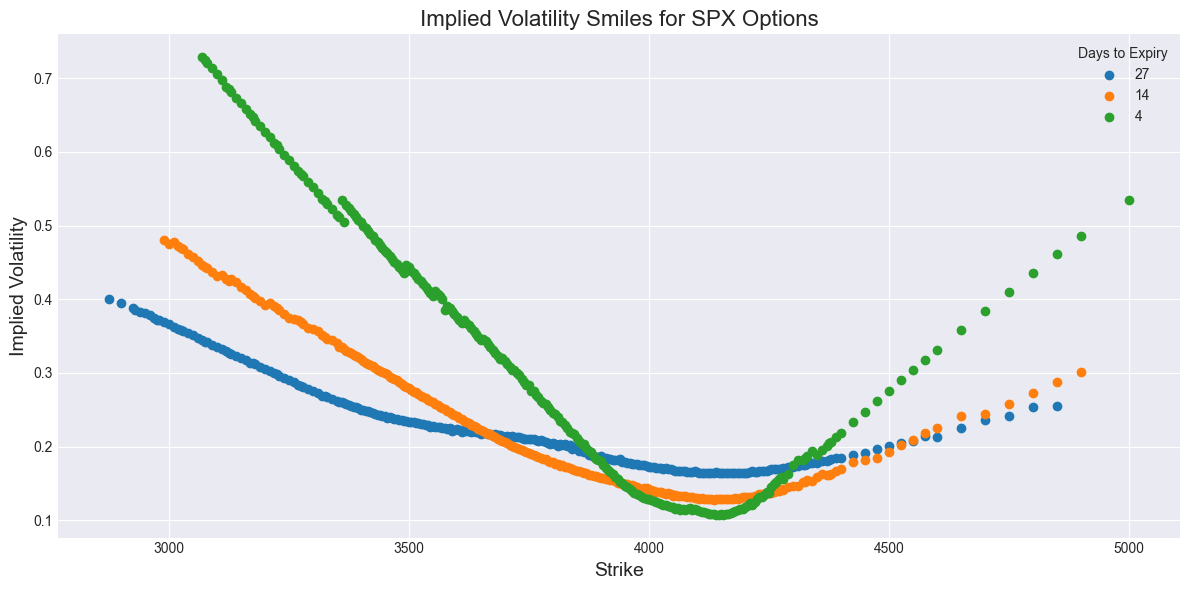

In [5]:
# Extract unique DTEs available
available_dtes = sorted(eom_options['dte'].unique())

# Extratc DTEs closest to 30, 15 and 1 resp.
dte_30 = max([d for d in available_dtes if d <= 30], default=None)
dte_15 = min(available_dtes, key=lambda x: abs(x - 15))
dte_1 = min([d for d in available_dtes if d > 1], default=None)

target_dtes = [int(d) for d in [dte_30, dte_15, dte_1] if d is not None]

iv_smiles = {}
for dte in target_dtes:
    iv_smile = compute_iv_smile(eom_options, dte)
    iv_smiles[dte] = iv_smile

ph.plot_iv_smiles(iv_smiles, "SPX")

For larger DTEs, the implied volatility skew takes the shape of a smirk, with moderately elevated IVs for OTM puts. As DTE approaches zero, the skew becomes much steeper, reflecting increased sensitivity to short-term downside risk.

# **Remove illiquid options**

To ensure more realistic and robust backtest results, we remove illiquid options. These contracts typically suffer from wide bid-ask spreads and poor fill quality, making them expensive to trade and potentially eroding any theoretical edge.

In [6]:
options = reshape_options_wide_to_long(options)
options.head()

,strike,underlying_last,dte,expiry,delta,iv,last,volume,bid,ask,option_type
date,,,,,,,,,,,
2020-01-02,100.0,3258.14,351.0,2020-12-18,1.00000,NaN,3067.54,1.0,3088.70,3105.00,C
2020-01-02,100.0,3258.14,715.0,2021-12-17,1.00000,NaN,2970.07,1.0,3028.90,3043.01,C
2020-01-02,100.0,3258.14,351.0,2020-12-18,-0.00005,1.00077,0.05,20.0,0.00,0.05,P
2020-01-02,100.0,3258.14,715.0,2021-12-17,0.00000,0.73271,0.07,59.0,0.00,0.09,P
2020-01-02,200.0,3258.14,351.0,2020-12-18,1.00000,NaN,2774.69,7.0,2990.51,3007.20,C


## Volume Filter

Since Open Interest is not available in our dataset, we use daily traded **volume** as a proxy for option contract liquidity. While not a perfect substitute, volume provides a reasonable indication of market activity and tradability. 

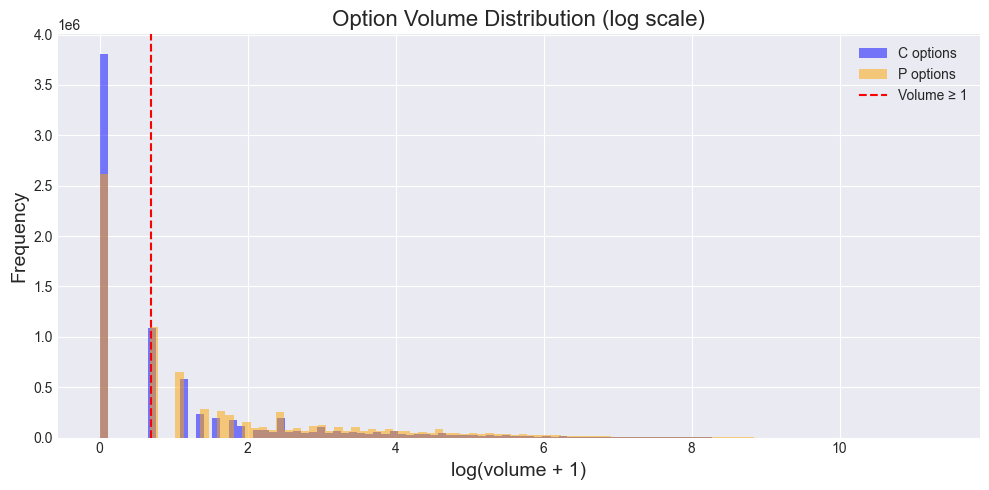

In [7]:
# Add 1 to avoid log(0), then take log
log_volumes = (options["volume"] + 1).apply(np.log)
ph.plot_volume_filter(options, log_volumes)

We remove options with very low volume (e.g., volume < 1), as these are likely illiquid and may not reflect reliable pricing or realistic execution.

In [8]:
volume_threshold = 1

## Bid-Ask Spread Filter

The bid-ask spread is a key measure of transaction cost and liquidity. Options with wide spreads are harder to trade efficiently and may reflect stale or unreliable pricing.

First we drop 0 ask and bid values, as they indicate that no trading occured at a particular date for a specific option.


Now we filter out options where the **relative bid-ask spread** exceeds a threshold (e.g., 25%), defined as:

$$
\text{Relative Spread} = \frac{\text{Ask} - \text{Bid}}{0.5 \times (\text{Ask} + \text{Bid})}
$$

In [9]:
options["mid"] = 0.5 * (options["bid"] + options["ask"])
options["rel_spread"] = (options["ask"] - options["bid"]) / options["mid"]
options[["bid", "ask", "mid", "rel_spread"]]

,bid,ask,mid,rel_spread
date,,,,
2020-01-02,3088.70,3105.00,3096.850,0.005263
2020-01-02,3028.90,3043.01,3035.955,0.004648
2020-01-02,0.00,0.05,0.025,2.000000
2020-01-02,0.00,0.09,0.045,2.000000
2020-01-02,2990.51,3007.20,2998.855,0.005565
...,...,...,...,...
2023-12-29,3.50,13.00,8.250,1.151515
2023-12-29,6348.40,6435.30,6391.850,0.013595
2023-12-29,6033.50,6087.70,6060.600,0.008943


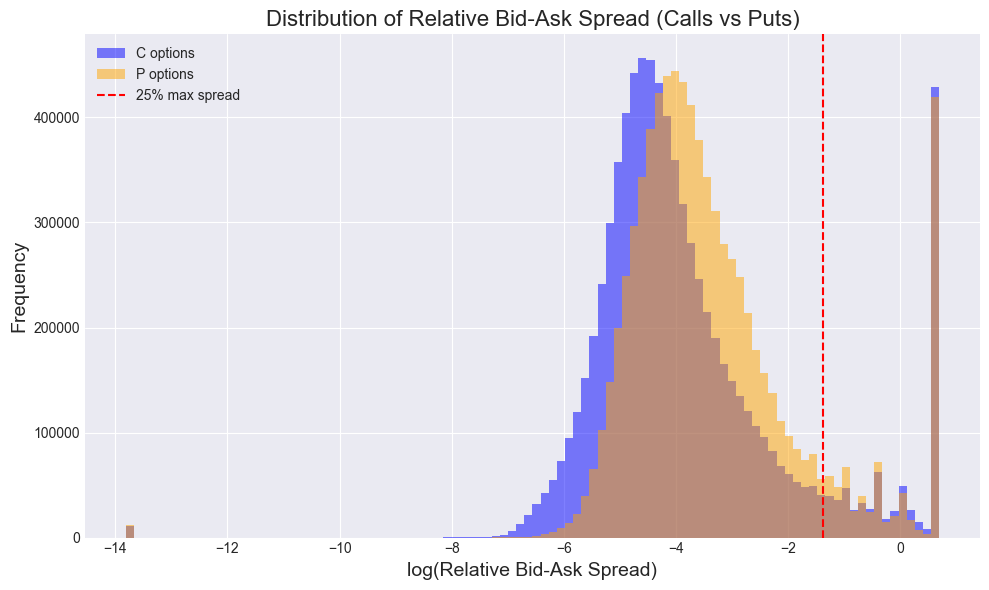

In [10]:
ph.plot_bid_ask_filter(options)

A threshold of 25% seems a reasonble choice for removing too large bid-ask spreads.

In [11]:
spread_threshold = 0.25

## Moneyness filter

We filter options based on their moneyness (strike / underlying price) to focus on contracts with meaningful market activity. Deep ITM or far OTM options are often illiquid or mispriced, so we retain only those within a reasonable band (e.g., 0.8 to 1.2).

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_71524/3178138296.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  options.groupby(["option_type", "moneyness_bin"])["volume"]


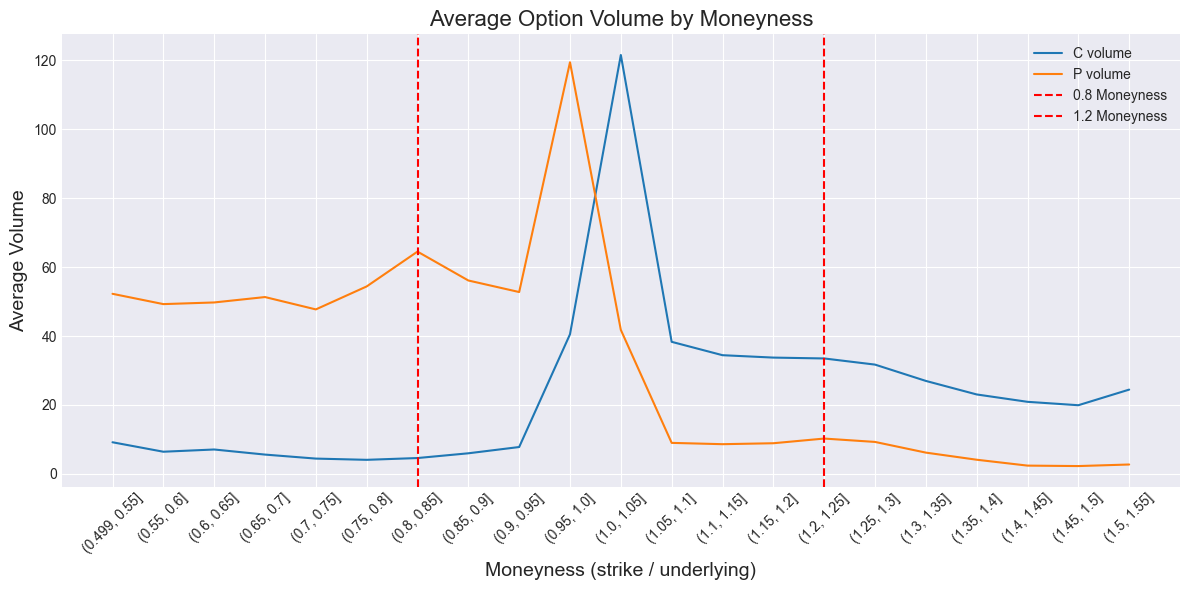

In [12]:
options["moneyness"] = options["strike"] / options["underlying_last"]

options["moneyness_bin"] = pd.cut(
    options["moneyness"],
    bins=np.arange(0.5, 1.6, 0.05),
    include_lowest=True
)

avg_vol = (
    options.groupby(["option_type", "moneyness_bin"])["volume"]
    .mean()
    .reset_index()
)

ph.plot_moneyness_filter(avg_vol)

We observe that average volume for OTM Calls drops sharply beyond a moneyness of 1.2, indicating low liquidity. For OTM Puts, volume remains relatively high down to a moneyness of 0.8, but falls off below that. Therefore, we retain options within the band [0.8, 1.2] to focus on the most liquid and tradeable strikes.

In [13]:
options = options.drop("moneyness_bin", axis=1)
moneynes_lower_band = 0.8
moneynes_upper_band = 1.2

## Apply the filters

In [14]:
n = len(options)

# Volume filter
options = options[options["volume"] >= volume_threshold].copy()

# Bid-Ask filter
options = options[(options["bid"] > 0) & (options["ask"] > 0)].copy()
options = options[options["rel_spread"] <= spread_threshold].copy()

# Moneyness filter
options = options[(options["moneyness"] >= moneynes_lower_band) &
                  (options["moneyness"] <= moneynes_upper_band)]

pct_dropped = 100 * (1 - len(options) / n)
print(f"Percentage of observations dropped across all filters: {pct_dropped:.2f}%")

Percentage of observations dropped across all filters: 58.21%


# **Build the Synthetic 30-DTE Skew**

To measure skew consistently, we compare the implied volatilities of an OTM put and call at a fixed 30-day time-to-expiry. Since shorter-dated options tend to show steeper skews and longer-dated ones flatter, holding expiry constant allows for meaningful comparisons over time.

We construct a synthetic 30-DTE skew by interpolating between the two closest expiries bracketing 30 days. While not directly tradable, this synthetic skew mirrors what institutional desks track and isolates true shifts in sentiment from calendar-driven effects.

## Compute Interpolated 30-DTE IVs

To construct the 30-day implied volatilities, we interpolate between the two expiries that bracket 30 DTE — one below $T_1$ and one above $T_2$. For choosing the strike, we are going to use a method called **delta targeting**, which consists in choosing the strikes such that the delta is ±0.25.

In addition, instead of interpolating the full volatility smile, we focus only on the options of interest:

- A 25-delta **put** and **call**, denoted: $IV^{Put}_{30DTE}$, $IV^{Call}_{30DTE}$
  
- An **ATM IV**, estimated as the average of call and put IVs with delta ≈ 0


The interpolation is performed in total variance space using:

$$
V_* = V_1 + \frac{T_* - T_1}{T_2 - T_1} \cdot (V_2 - V_1)
\qquad
IV_* = \sqrt{\frac{V_*}{T_*}}
$$

Where:

$$
V_i = IV_i^2 \cdot \frac{DTE_i}{252}
$$

This gives us smooth and consistent synthetic 30-DTE IVs for measuring skew over time.

In [15]:
def interp_iv(df_lower, df_upper, T1, T2, target_dte, target_delta, max_delta_error=0.1):
    """
    If T1 == T2, returns the closest-delta IV from df_lower.
    Otherwise, finds the closest-delta rows in df_lower and df_upper
    within max_delta_error and linearly interpolates variance to target_dte.
    """
    # Helper to pick the best row within delta tolerance

    # If both expiries are identical, just return that IV    
    if T1 == T2:
        row = pick_quote_row(df_lower, target_delta, max_delta_error)
        return row.iv if row is not None else np.nan

    # Otherwise pick one row from each expiry
    row1 = pick_quote_row(df_lower, target_delta, max_delta_error)
    row2 = pick_quote_row(df_upper, target_delta, max_delta_error)
    if row1 is None or row2 is None:
        return np.nan

    # Term‐structure interpolation of variance
    t1, t2 = T1 / 252, T2 / 252
    V1 = row1.iv**2 * t1
    V2 = row2.iv**2 * t2
    tT = target_dte / 252

    Vt = V1 + (tT - t1) / (t2 - t1) * (V2 - V1)
    return np.sqrt(Vt / tT) if Vt > 0 else np.nan


def pick_quote_row(df_leg, target_delta, max_delta_error):
    df2 = df_leg.copy()
    df2['d_err'] = (df2['delta'] - target_delta).abs()
    df2 = df2[df2['d_err'] <= max_delta_error]
    if df2.empty:
        return None
    return df2.iloc[df2['d_err'].argmin()]

## Compute the 25-Delta Skew

To systematically measure asymmetry in implied volatility across strikes, we compute the **25-delta skew** — a standard metric in volatility trading.

Instead of relying on fixed moneyness levels (e.g., 90% / 110%), we use **delta targeting**, selecting the OTM put and call with deltas near -0.25 and +0.25. This approach is more robust, as delta accounts for the strike, expiry, volatility, and underlying price — resulting in a consistent and normalized strike selection.

The absolute 25-delta skew is given by:

$$
25\Delta\ \text{Skew} = IV_{25\Delta\,Put} - IV_{25\Delta\,Call}
$$

Lastly, we normalize the absolute skew by the ATM IV to obtain a scale-invariant measure, allowing for fair comparisons across time, assets, and expiries — even in different volatility regimes.
$$
\text{Normalized Skew} = \frac{IV_{25\Delta\,Put} - IV_{25\Delta\,Call}}{IV_{ATM}}
$$

In [16]:
def compute_skew(iv_put, iv_call, iv_atm):
    skew_abs = iv_put - iv_call
    skew_norm = skew_abs / iv_atm if iv_atm and not np.isnan(iv_atm) else np.nan
    return skew_abs, skew_norm

## Compute the Synthetic 30-DTE 25-Delta Skew

Now we bring everything together by applying the previous steps for each trading day to compute the synthetic skew.

For each date *t*, we proceed as follows:

**Step 1:** Extract the two expiries closest to the 30-day target — one below and one above.

**Step 2:** For each expiry, filter the options to find the contracts with deltas closest to ±0.25 — representing the 25-delta OTM **put** and **call**.

**Step 3:** Interpolate the implied volatilities of these 25-delta options in total variance space to obtain a synthetic 30-DTE IV for both put and call.

**Step 4:** Repeat the interpolation for **ATM options**, using a target delta of 0 for both puts and calls.

**Step 5:** Compute the **ATM IV** as the average of the interpolated ATM call and put IVs.

**Step 6:** Compute the skew:
- **Absolute skew**: $\text{Skew}_{\text{abs}} = IV_{\text{put}} - IV_{\text{call}}$
- **Normalized skew**: $\text{Skew}_{\text{norm}} = \frac{IV_{\text{put}} - IV_{\text{call}}}{IV_{\text{ATM}}}$

In [17]:
def compute_synthetic_skew(options, 
                           target_dte=30, 
                           target_delta_otm=0.25,
                           target_delta_atm=0.5,
                           delta_tolerance=0.05,
                           max_dte_diff=7,
                           min_total_quotes=5,
                           min_band_quotes=2):
    results = []
    log = []

    for date, df in options.groupby("date"):
        T1, T2 = find_viable_expiries(
            df, target_dte, max_dte_diff, 
            min_total_quotes, min_band_quotes,
            delta_tolerance, target_delta_otm
        )

        if T1 is None or T2 is None:
            continue

        df1, df2 = df[df.dte == T1], df[df.dte == T2]
        df1_call = df1[(df1.option_type == 'C')]
        df1_put  = df1[(df1.option_type == 'P')]
        df2_put  = df2[(df2.option_type == 'P')]
        df2_call = df2[(df2.option_type == 'C')]
        
        # OTM Put IV 
        iv_put  = interp_iv(df1_put, df2_put, T1, T2, 
                            target_dte, -target_delta_otm)
        # OTM Call IV 
        iv_call = interp_iv(df1_call, df2_call, T1, T2,
                            target_dte, target_delta_otm)

        # ATM Put & Call IV
        iv_atm_put  = interp_iv(df1_put, df2_put, T1, T2, 
                                target_dte, -target_delta_atm)
        iv_atm_call = interp_iv(df1_call, df2_call, T1, T2, 
                                target_dte, target_delta_atm)
        iv_atm = np.nanmean([iv_atm_call, iv_atm_put])

        skew_abs, skew_norm = compute_skew(iv_put, iv_call, iv_atm)

        row_put1  = pick_quote_row(df1_put,  -target_delta_otm, delta_tolerance)
        row_call1 = pick_quote_row(df1_call,  target_delta_otm, delta_tolerance)

        results.append({
            'date':       date,
            'iv_put_30':  iv_put,
            'iv_call_30': iv_call,
            'iv_atm_30':  iv_atm,
            'skew_abs':   skew_abs,
            'skew_norm':  skew_norm,
        })

        log.append({       
            'date': date,     
            'T1': T1,
            'T2': T2,
            'delta_put_1':  row_put1.delta  if row_put1  is not None else np.nan,
            'd_err_put_1':  row_put1.d_err   if row_put1  is not None else np.nan,
            'delta_call_1': row_call1.delta if row_call1 is not None else np.nan,
            'd_err_call_1': row_call1.d_err  if row_call1 is not None else np.nan
        })
    
    results = pd.DataFrame(results).set_index('date').sort_index()
    log = pd.DataFrame(log).set_index('date').sort_index()

    return results, log


def find_viable_expiries(
    df,
    target_dte,
    max_dte_diff=7,
    min_total_quotes=5,
    min_band_quotes=2,
    delta_tolerance=0.05,
    target_delta_otm=0.25
):
    # collect expiries within calendar tolerance
    exps = np.sort(df['dte'].dropna().unique())
    exps = exps[np.abs(exps - target_dte) <= max_dte_diff]
    if len(exps) < 2:
        return None, None

    # split into “lower” and “upper” lists
    lowers = exps[exps <= target_dte]
    uppers = exps[exps >= target_dte]

    def find_best(candidates):
        # sort by closeness to target
        for dte in sorted(candidates, key=lambda d: abs(d - target_dte)):
            sub = df[df['dte'] == dte]

            # total liquidity check
            if len(sub) < min_total_quotes:
                continue

            # band liquidity check for both puts and calls
            def band_count(opt_sub, tgt):
                return opt_sub[np.abs(opt_sub['delta'] - tgt) <= delta_tolerance].shape[0]

            puts = sub[sub.option_type == 'P']
            calls = sub[sub.option_type == 'C']

            if (band_count(puts, -target_delta_otm) < min_band_quotes or
                band_count(calls,  target_delta_otm) < min_band_quotes):
                continue

            return dte

        return None

    T1 = find_best(lowers)
    T2 = find_best(uppers)
    return T1, T2

In [18]:
synthetic_skew, log = compute_synthetic_skew(options, target_dte=30)
synthetic_skew

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_71524/2511968751.py:40: RuntimeWarning: Mean of empty slice
  iv_atm = np.nanmean([iv_atm_call, iv_atm_put])


,iv_put_30,iv_call_30,iv_atm_30,skew_abs,skew_norm
date,,,,,
2020-01-02,0.125564,0.082891,0.096460,0.042673,0.442391
2020-01-03,0.143961,0.094049,0.114490,0.049912,0.435949
2020-01-06,0.141200,0.093460,0.112400,0.047740,0.424733
2020-01-07,0.142189,0.096633,0.114831,0.045556,0.396725
2020-01-08,0.145090,0.092990,0.110795,0.052100,0.470238
...,...,...,...,...,...
2023-12-22,0.118545,0.103150,0.106070,0.015396,0.145145
2023-12-26,0.120178,0.101201,0.106165,0.018977,0.178749
2023-12-27,0.114400,0.097640,0.101930,0.016760,0.164427


In [ ]:
synthetic_skew = synthetic_skew.dropna()

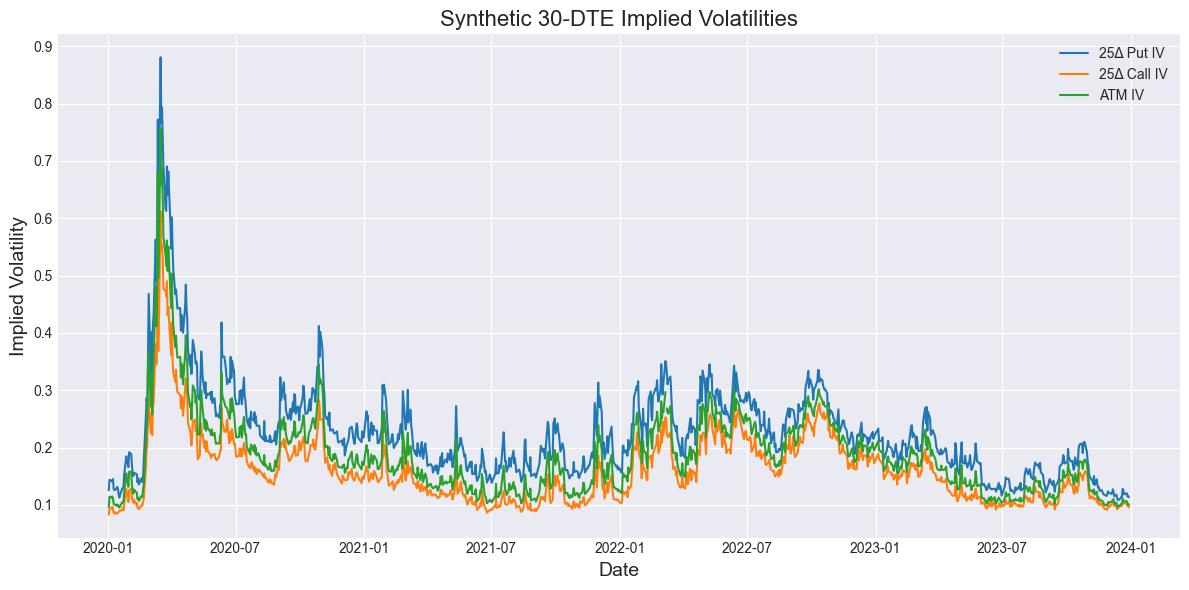

In [20]:
ph.plot_synthetic_ivs(synthetic_skew)

The relative ordering aligns with the typical smirk-shaped skew observed in equity index options, where the **IV of the OTM put is highest**, followed by the **ATM IV**, and finally the **OTM call IV as the lowest**. All three series generally move in the same direction, which is expected given their shared dependence on overall market volatility. 

Notably, the **OTM put IV exhibits greater variability**, reflecting its heightened sensitivity to downside risk and demand for crash protection.

In [21]:
synthetic_skew[["iv_put_30", "iv_atm_30", "iv_call_30"]].corr()

,iv_put_30,iv_atm_30,iv_call_30
iv_put_30,1.000000,0.988525,0.964624
iv_atm_30,0.988525,1.000000,0.991622
iv_call_30,0.964624,0.991622,1.000000


In [22]:
synthetic_skew[["iv_put_30", "iv_atm_30", "iv_call_30"]].std()

iv_put_30     0.089915
iv_atm_30     0.077295
iv_call_30    0.064570
dtype: float64

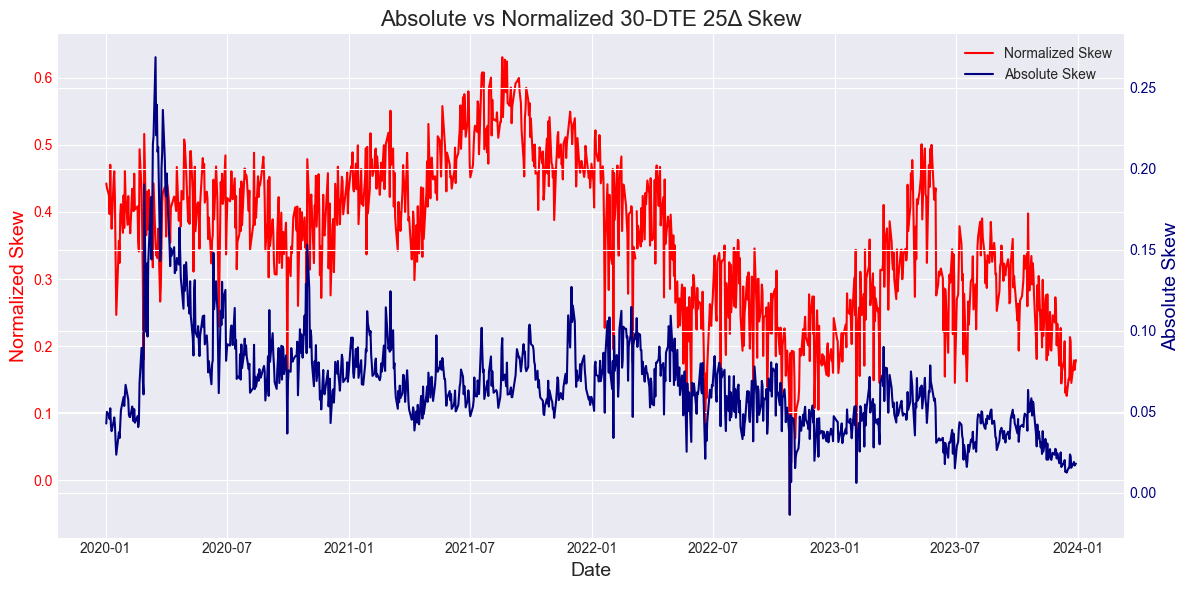

In [23]:
ph.plot_norm_abs_skew(synthetic_skew)

As shown, the absolute skew is more sensitive to changes in volatility regimes and exhibits higher noise over time — particularly during the first three months of heightened volatility. In contrast, the normalized skew remains more stable, making it better suited for generating consistent and reliable trading signals.

<a id='strat'></a>
# **5. Implement Trading Strategies**

We now leverage the skew metrics computed earlier to design and test trading strategies. The core idea we focus on is the empirically observed **mean-reverting behavior of the skew**.

In the first part, we introduce the option structure used to express trades based on the skew signal.

In the second part, we build the mean-reversion skew trading strategy itself, starting with simple signal definitions and progressively adding filters to improve trade quality.

## **5.1. Trade Expression Setup**

In options trading, skew is often **traded directly** using options structures that isolate the relative pricing of puts vs. calls. In our case we will trade the **Risk Reversal** structure whihc mimic the absolute skew as it consits in selling a 25Δ put and buy a 25Δ call when the skew is too steep and vice versa.

This notebook primarily focuses on **trading the skew directly through such option structures**, as they allow us to:
- Express a **pure view on volatility skew**,
- Minimize directional exposure (compared to trading the underlying),
- And benefit from changes in the **shape of the implied volatility surface**.

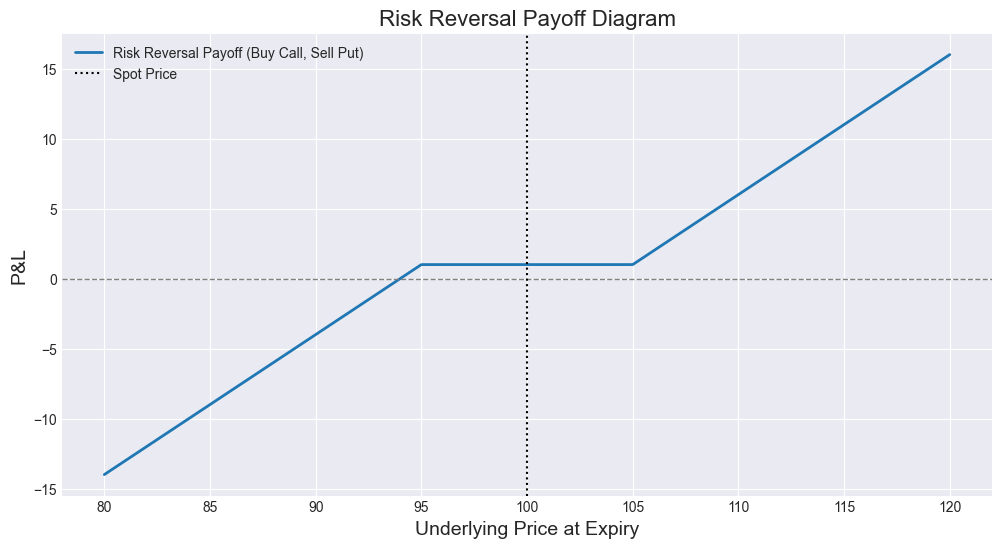

In [24]:
ph.plot_risk_reversal_payoff(spot_price=100, strike_put=95, strike_call=105, premium_put=3, premium_call=2)

This payoff represents the P&L we would earn if we held the options until expiry, which is rarely the case in skew trading. Intuitively, when the stock price declines, the skew tends to steepen, and since we are betting on a mean reversion of the skew (i.e., a flattening), this move results in a loss.

## **5.2. Strategy 1: Simple Mean Reversion on the Skew**

This strategy is based on the observation that skew tends to exhibit **mean-reverting behavior**. When the skew becomes abnormally high or low, it often reverts toward its long-term average.

We explore two methods:
1. A **fixed absolute skew threshold** approach, using static cutoff levels.
2. A **rolling z-score threshold** approach, which dynamically adjusts based on recent skew behavior.

Both methods provide a framework for identifying potential reversal points in the skew and constructing contrarian trades.

## **5.2.1 Signal 1: Fixed Absolute Skew Threshold**

This method is commonly used in exploratory research due to its simplicity and interpretability. It uses fixed absolute skew levels to identify extreme market conditions and trigger contrarian trades.

We define two static thresholds:

- **Upper threshold** $(\text{Skew}_{\text{Upper}})$: indicates excessive downside protection demand, a potential market top.
- **Lower threshold** $(\text{Skew}_{\text{Lower}})$: indicates complacency or upside overpricing, a potential market bottom.

These thresholds are chosen based on historical data and should be calibrated using a training sample to avoid forward-looking bias.

### **Trading Signals**

- **Long Signal**: Buy a reversed risk reversal when: $\text{Skew}_t < \text{Skew}_{\text{Lower}}$

- **Short Signal**: Buy a risk reversal when: $\text{Skew}_t > \text{Skew}_{\text{Upper}}$

- **Exit Signal**: Close the position when: $\text{Skew}_{\text{Lower}} \leq \text{Skew}_t \leq \text{Skew}_{\text{Upper}}$

This logic defines a simple contrarian trading strategy based on the assumption that extreme skew levels tend to revert toward a long-term equilibrium.

In [24]:
def threshold_strategy(skew, lower_threshold=0.01, upper_threshold=0.05):
    signals = pd.DataFrame(index=skew.index)
    signals["long"] = False
    signals["short"] = False
    signals["exit"] = False
    signals["position"] = 0

    position = 0  # +1 = long, -1 = short, 0 = flat

    for i in range(len(skew)):
        if pd.isna(skew.iloc[i]):
            continue

        date = skew.index[i]
        value = skew.iloc[i]

        if position == 0:
            if value < lower_threshold:
                signals.at[date, "long"] = True
                position = 1
            elif value > upper_threshold:
                signals.at[date, "short"] = True
                position = -1
        else:
            if value >= lower_threshold and value <= upper_threshold:
                signals.at[date, "exit"] = True
                position = 0

        signals.at[date, "position"] = position

    return signals

According to the plot it seems reasonbale to use a lwoer an dupper thrteshold of 0.02 and 0.06 respectively.

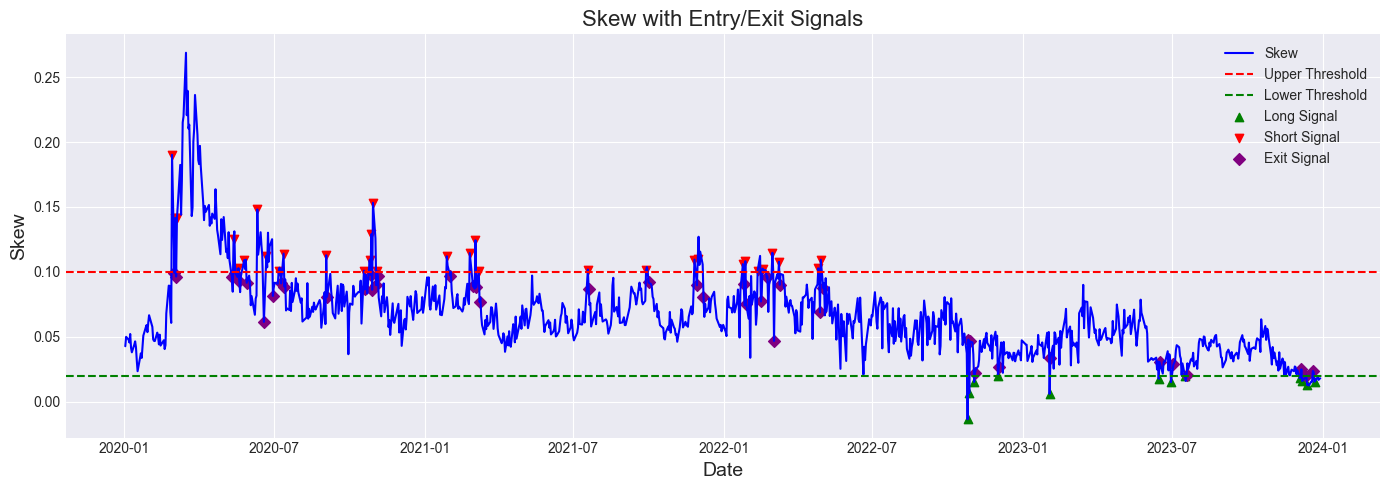

In [31]:
upper_threshold = 0.1
lower_threshold = 0.02

signals_abs_threshold = threshold_strategy(synthetic_skew["skew_abs"], lower_threshold, upper_threshold)

ph.plot_skew_signals(synthetic_skew["skew_abs"], signals_abs_threshold, lower_threshold, upper_threshold)

While this approach is straightforward to implement, it is **not adaptive** to changing volatility regimes and therefore requires caution. Moreover, by selecting thresholds on the same dataset used for backtesting, we introduce a **data-snooping bias**. To mitigate this, we will calibrate and evaluate our signals using a proper **walk-forward** framework later in Section 6.

## **5.2.2 Signal 2: Rolling Z-Score of the Skew**

COmpared to the the static fixed threshold appraoch which considers a fixed trheshold for the entire period, the rolling z score(a.k.a Bollnger Bands) adapts the buyign and selling threhsold based on markt conditons. When the voilaitltiy is higher the lower and upper threhsold will go away form the mean, so in low volaitltiy regimes the band will be anrrower but during high voality the band will spread out.

When the skew becomes extremely high or low relative to its historical average, it may signal fear or complacency in the market:

- A **high skew Z-score** implies elevated demand for downside protection → potential **market top or correction** ahead.
- A **low skew Z-score** implies low demand for puts → potential **bounce or rally** ahead.


We define the Z-score of the skew as:

$$
Z_t = \frac{\text{Skew}_t - \mu_{\text{Skew}}}{\sigma_{\text{Skew}}}
$$

Where:
- $\text{Skew}_t$ is the skew on day *t*
- $\mu_{\text{Skew}}$ is the rolling mean of the skew
- $\sigma_{\text{Skew}}$ is the rolling standard deviation

In [26]:
def compute_zscore(series, window=60):
    return (series - series.rolling(window).mean()) / series.rolling(window).std()

synthetic_skew["skew_zscore"] = compute_zscore(synthetic_skew["skew_abs"], window=60)

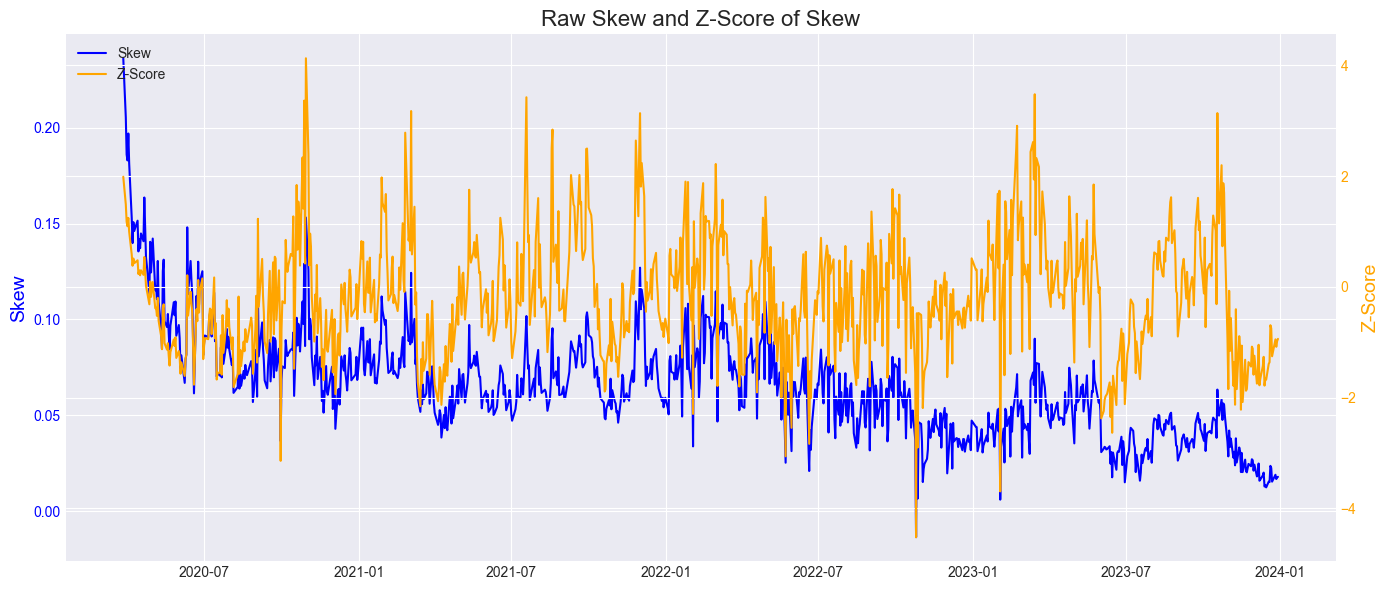

In [27]:
ph.plot_skew_vs_zscore(synthetic_skew)

When the skew makes a sudden large move, the z-score amplifies that move relative to its recent volatility and average value, making it easier to spot extreme events.

#### **Trading Signals**

- **Short Signal**: Buy a risk reversal when: $Z_t > Z_{entry}$

- **Long Signal**: Buy a reversed risk reversal when: $Z_t < -Z_{entry}$

- **Exit Signal**: Close any position when:  $-Z_{exit} ≤ Z_t ≤ Z_{exit}$

In most implementations:  
- $Z_{entry} = 1.5$
- $Z_{exit}  = 0.5$

This approach assumes that extreme deviations in skew (captured by z-scores) reflect **excess fear or complacency**, providing contrarian entry and exit points.

In [28]:
def z_score_strategy(z_score, entry_threshold=2, exit_threshold=0.5):
    signals = pd.DataFrame(index=z_score.index)
    signals["long"] = False
    signals["short"] = False
    signals["exit"] = False
    signals["position"] = 0

    position = 0  # +1 = long, -1 = short, 0 = flat
    for i in range(len(z_score)):
        if pd.isna(z_score.iloc[i]):  # Skip NaN values for rolling
            continue

        if position == 0: 
            # Enter long position
            if z_score.iloc[i] < -entry_threshold:
                signals.at[z_score.index[i], "long"] = True
                position = 1
            # Enter short position
            elif z_score.iloc[i] > entry_threshold:
                signals.at[z_score.index[i], "short"] = True
                position = -1 

        elif position == 1: 
            # Exit long position
            if z_score.iloc[i] >= -exit_threshold:
                signals.at[z_score.index[i], "exit"] = True
                position = 0

        elif position == -1:
            # Exit short position
            if z_score.iloc[i] <= exit_threshold:
                signals.at[z_score.index[i], "exit"] = True
                position = 0

        signals.loc[z_score.index[i], "position"] = position

    return signals

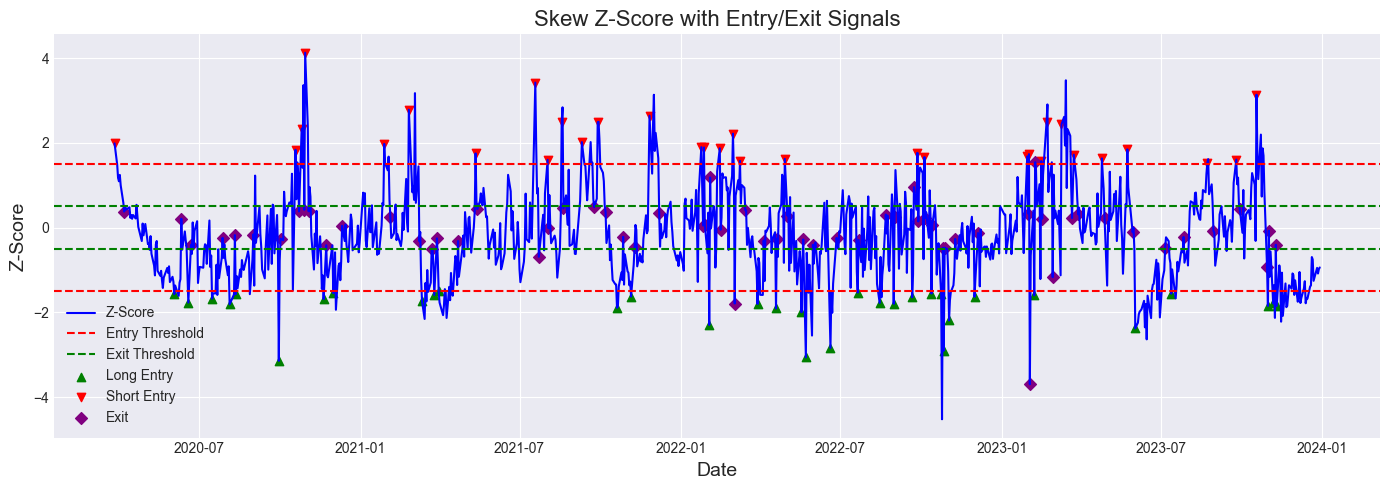

In [29]:
entry_threshold = 1.5
exit_threshold = 0.5

signals_zscore = z_score_strategy(synthetic_skew["skew_zscore"], entry_threshold, exit_threshold)

ph.plot_zscore_signals(synthetic_skew["skew_zscore"], signals_zscore, entry_threshold, exit_threshold)

To make it more obvious about how the staretgye adapts to the market condition, we plot the skew on top of the rollign mean and upper and lower bands computed based on mutilple of the rolling standard deviations.



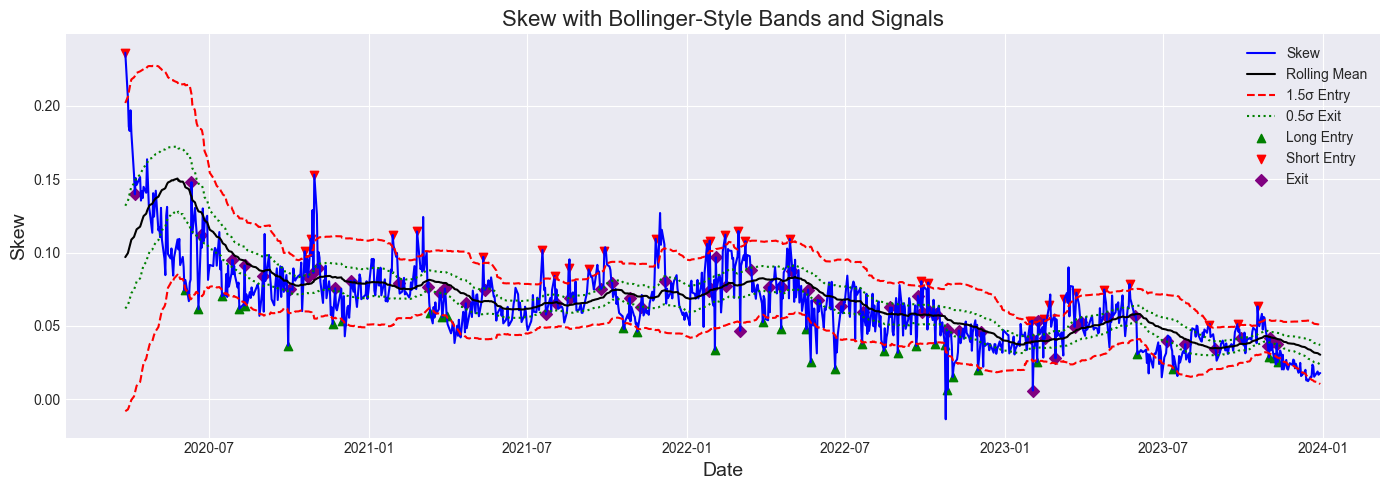

In [30]:
ph.plot_boll_bands(synthetic_skew, signals_zscore)

## **5.3. Strategy 2: Mean Reversion with Momentum, IVP, and Macro Filters**

Using the **rolling Z-score of the skew** in isolation can lead to a high number of **false positives**. While skew often exhibits mean-reverting tendencies, this behavior is not always reliable — especially during trending or high-volatility regimes.

To reduce noise and increase **signal quality**, we introduce several **filters** that must be satisfied before a trade is taken. These filters aim to validate the skew signal in the broader market context.


### **5.3.3 Volatility Regime Filter: IV Percentile (IVP)**

The **Implied Volatility Percentile (IVP)** indicates the relative level of implied volatility compared to its own history.

- **Logic**: Skew behaves differently in high vs. low vol regimes.
- **Filter Rule**:  Only trade when  **20% ≤ IVP ≤ 80%**
- **Rationale**:
  - **IVP > 80%** → panic regime, skew may remain dislocated.
  - **IVP < 20%** → complacent regime, reversion may not trigger.
  - Staying in the middle range improves reliability of the signal.


In [56]:
synthetic_skew["iv_atm_30"][synthetic_skew["iv_atm_30"].isna()]

Date
2022-03-08   NaN
Name: iv_atm_30, dtype: float64

In [50]:
synthetic_skew["iv_atm_30"].loc["2022-09"]

Date
2022-09-01    0.223083
2022-09-02    0.225398
2022-09-06    0.238253
2022-09-07    0.218765
2022-09-08    0.209410
2022-09-09    0.202964
2022-09-12    0.212923
2022-09-13    0.236534
2022-09-14    0.233640
2022-09-15    0.239273
2022-09-16    0.239171
2022-09-19    0.234864
2022-09-20    0.248343
2022-09-21    0.261120
2022-09-22    0.250213
2022-09-23    0.266560
2022-09-26    0.286920
2022-09-27    0.289561
2022-09-28    0.271410
2022-09-29    0.277884
2022-09-30    0.277082
Name: iv_atm_30, dtype: float64

In [49]:
synthetic_skew["ivp"].loc["2022-09"]

Date
2022-09-01   NaN
2022-09-02   NaN
2022-09-06   NaN
2022-09-07   NaN
2022-09-08   NaN
2022-09-09   NaN
2022-09-12   NaN
2022-09-13   NaN
2022-09-14   NaN
2022-09-15   NaN
2022-09-16   NaN
2022-09-19   NaN
2022-09-20   NaN
2022-09-21   NaN
2022-09-22   NaN
2022-09-23   NaN
2022-09-26   NaN
2022-09-27   NaN
2022-09-28   NaN
2022-09-29   NaN
2022-09-30   NaN
Name: ivp, dtype: float64

In [51]:
del synthetic_skew["ivp"]

In [52]:
def compute_iv_percentile(iv_series, window=252):
    return iv_series.rolling(window).apply(
        lambda x: (x[-1] > x).sum() / window,
        raw=True
    )

synthetic_skew["ivp"] = compute_iv_percentile(synthetic_skew["iv_atm_30"])
synthetic_skew["ivp"]

Date
2020-01-02         NaN
2020-01-03         NaN
2020-01-06         NaN
2020-01-07         NaN
2020-01-08         NaN
                ...   
2023-12-21    0.174603
2023-12-22    0.103175
2023-12-26    0.107143
2023-12-27    0.043651
2023-12-28    0.027778
Name: ivp, Length: 986, dtype: float64

<Axes: xlabel='Date'>

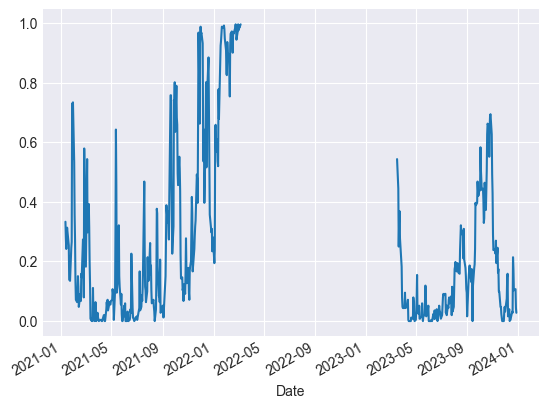

In [53]:
synthetic_skew["ivp"].plot()

### **5.3.1 Macro Filter: VIX**

The **VIX index** captures the market's expectation of near-term volatility and serves as a proxy for investor fear and systemic stress.

- **Logic**: Skew reversals tend to fail during extreme volatility spikes.
- **Filter Rule**:  Only trade when  **VIX < 20**
- **Rationale**: In periods of market panic, skew can remain elevated for long stretches, making reversal signals unreliable.

In [33]:
start_date = synthetic_skew.index[0].date()
end_date = synthetic_skew.index[-1].date()

vix = yf.download("^VIX", start=start_date, end=end_date)
vix = vix["Close"]
vix.columns = ["Vix"]
vix.index.name = "Date" 

common_dates = synthetic_skew.index.intersection(vix.index)
vix = vix.loc[common_dates]
synthetic_skew = synthetic_skew.loc[common_dates]
synthetic_skew.index.name = "Date"
vix.index.name = "Date" 

vix

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_70277/1489900883.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


,Vix
Date,
2020-01-02,12.47
2020-01-03,14.02
2020-01-06,13.85
2020-01-07,13.79
2020-01-08,13.45
...,...
2023-12-21,13.65
2023-12-22,13.03
2023-12-26,12.99


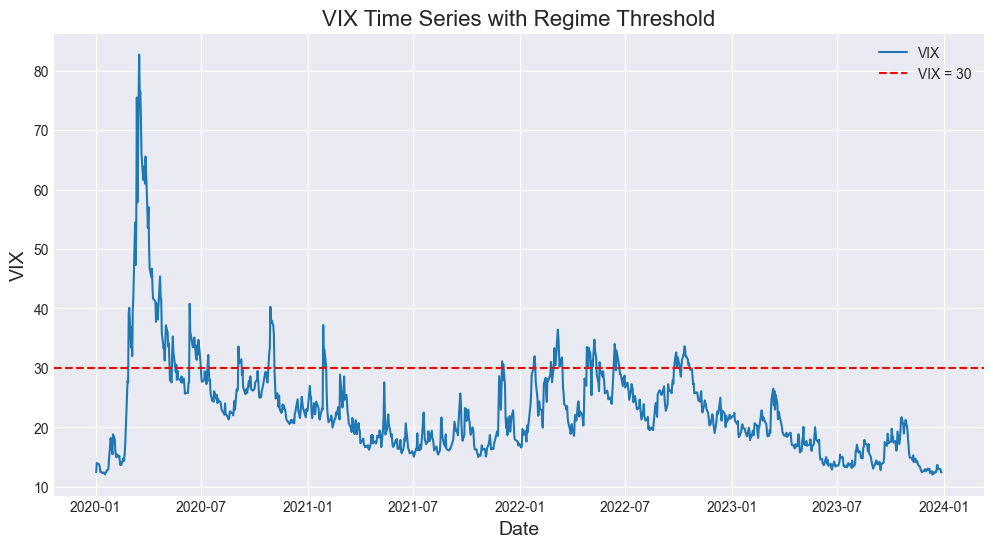

In [36]:
vix_threshold = 30
ph.plot_vix(vix, vix_threshold=vix_threshold)

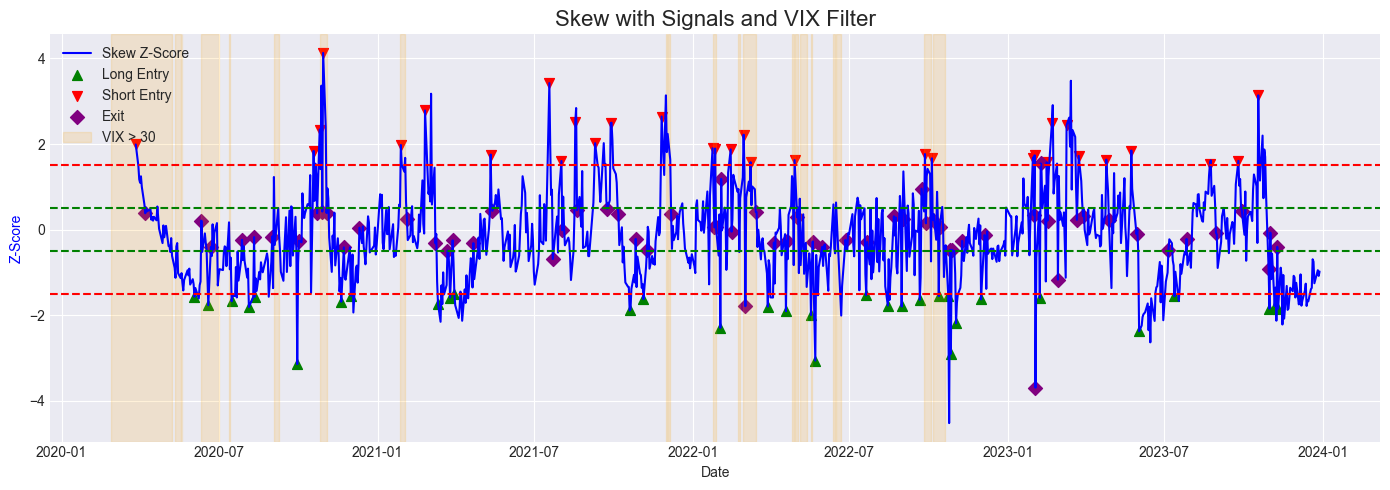

In [45]:
ph.plot_zscore_signals_with_vix(
    synthetic_skew["skew_zscore"], signals_zscore, vix, entry_threshold, exit_threshold, 
    vix_filter=vix_threshold, title="Skew with Signals and VIX Filter"
)

As shown, the correlation between SPY and the absolute skew is **more than twice** as strong as with the normalized version, so it indicates that we can use teh skew as **sentiment indicator** to take directional trades.

### **5.3.2 Momentum Filter: Underlying ROC**

The **Rate of Change (ROC)** indicator is used to measure short-term momentum in the underlying asset (e.g., SPY).

- **Logic**: Enter contrarian trades when the underlying has recently moved strongly in one direction.
- **Filter Rule**:
  - For **bullish skew** (skew too low): Require **10-day ROC < 0**
  - For **bearish skew** (skew too high): Require **10-day ROC > 0**
- **Rationale**: Helps confirm market is oversold or overbought, which supports the case for mean reversion in the skew.